## CS598DL4 Final Project Team 77

# DuETT: Dual Event Time Transformer for Electronic Health Records

Project Github Link: https://github.com/Spoon7227/CS598DL-Project

# Introduction

Electronic health records contain a wide range of time series data that is sparse and irregular which makes it hard to effectively model especially when considering the semantic relationship between different types of observations. Self-supervised transformers perform well with data with structured relationships, but straightforward applications struggle with EHRs due to it’s a structured relationship over 2 dimensions of time and recorded events. Self-attention layer’s quadratic scaling also limits the input data length. This paper aims to solve this problem by showcases the novel dual event time transformer (DueTT) approach for the task of mortality prediction.

This paper proposes 3 main novel methods.

Input representation: Input representation that incorporates event information (ex: frequency, missingness, …), uses early fusion of static variables of the patient (age, sex, ...), and aggregates observations. To be more specific, each event type is binned into time bins of equal duration to tackle the irregular and sparse nature of EHR time series data, this is then mapped to an embedding. Lastly, static variables are concatenated to the embeddings so each bin has access to that information. 

DuETT Architecture: Each DuETT layer has 2 transformer sublayers that attend to the event and time dimension of the embedding respectively. The overall model has multiple DuETT sublayers that is followed by self-supervised learning heads. This allows for the model to capture both the types of events and the time in which they are observed.

Self-supervised training: Perform pre-training that uses masked event modeling to train the model to capture important priors. This masking scheme is done along both time and event dimensions and predicts both the presence and absence of an event. Then, fine-tuning is done in a supervised manner. 

It is showcased that the DuETT's attention to both time and event types will yield more comprehensive EHR data representations and result in improved performance over other methods (XGBoost, LSTM, mTAND, Raindrop, STraTs) on the PhysioNet-2012 mortality task, achieving a AUROC of 0.872 ± 0.001 and Avg Precision of  0.564 ± 0.003.

This paper contributes to the research regime by proposing a transformer architecture and input transformation method that addresses both the hard to model nature of time-series data of EHR, and the limit of input data length on self-attention model complexity.


# Scope of Reproducibility:

Hypothesis: The DuETT's attention to both time and event types will yield more comprehensive EHR data representations and result in improved performance over other methods (XGBoost, LSTM, mTAND, Raindrop, STraTs) on the PhysioNet-2012 mortality task.

Experiments:

1. We will run the DuETT model on the PhysioNet-2012 mortality task using the same training parameter inorder to validate and replicate the original paper result.

Ablations planned:

1.   Input representation ablations: 
      - Investigate the use of the last occurring value in the bin as the aggregation functions of bins by comparing the performance with other methods (mean, max). 
      - Investigate the choice of injecting event & time embedding at each layer which should by only injecting at the first layer.
2.   Self-Supervised Learning Ablation: 
      - Investigate the impact of pre-training by skipping it entirely.
3.   Dual event & time transformer Ablation: 
      - Investigate the impact of having both event and time transformers by only having either event or time transformers.



# Methodology

This methodology is the core of your project. It consists of run-able codes with necessary annotations to show the expeiment you executed for testing the hypotheses.

The methodology at least contains two subsections **data** and **model** in your experiment.

In [1]:
# Used python version 3.9.18

# Install necessary packages
%pip install -r requirements.txt

# Torch with Cuda for GPU training
%pip install torch==1.13.1+cu117 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pytorch-lightning 1.6.1 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pytorch-lightning 1.6.1 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import numpy as np
import pytorch_lightning as pl
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchmetrics
import torch.nn.functional as F
import torch.nn as nn
import x_transformers
import matplotlib.image as mpimg
from pytorch_lightning.loggers import CSVLogger
import os

# Code based on Authors' Public Repository
import duett
import physionet
import train

In [3]:
# Use same seed as paper
seed = 2020
pl.seed_everything(seed)

Global seed set to 2020


2020

### Training Flag

In [4]:
# Flag to enable / Disable Training 
training = False

##  Data
Data includes raw data, descriptive statistics, and data processing.
  * Source of the data: where the data is collected from; if data is synthetic or self-generated, explain how. If possible, please provide a link to the raw datasets.
  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset.

## Dataset

The PhysioNet/Computing in Cardiology Challenge 2012: Predicting Mortality of ICU Patients

### Source of Data

This data consists of records from 12000 ICU stays and is accessed for this project through torchtime.data as well as from the official physionet website: https://physionet.org/content/challenge-2012/1.0.0/

### Data Descriptors

1. 37 Time Series Variales:

    0. Mins: Minutes since ICU admission. Derived from the PhysioNet time stamp.
    1. Albumin: Albumin (g/dL)
    2. ALP: Alkaline phosphatase (IU/L)
    3. ALT: Alanine transaminase (IU/L)
    4. AST: Aspartate transaminase (IU/L)
    5. Bilirubin: Bilirubin (mg/dL)
    6. BUN: Blood urea nitrogen (mg/dL)
    7. Cholesterol: Cholesterol (mg/dL)
    8. Creatinine: Serum creatinine (mg/dL)
    9. DiasABP: Invasive diastolic arterial blood pressure (mmHg)
    10. FiO2: Fractional inspired O\ :sub:`2` (0-1)
    11. GCS: Glasgow Coma Score (3-15)
    12. Glucose: Serum glucose (mg/dL)
    13. HCO3: Serum bicarbonate (mmol/L)
    14. HCT: Hematocrit (%)
    15. HR: Heart rate (bpm)
    16. K: Serum potassium (mEq/L)
    17. Lactate: Lactate (mmol/L)
    18. Mg: Serum magnesium (mmol/L)
    19. MAP: Invasive mean arterial blood pressure (mmHg)
    20. MechVent: Mechanical ventilation respiration (0:false, or 1:true)
    21. Na: Serum sodium (mEq/L)
    22. NIDiasABP: Non-invasive diastolic arterial blood pressure (mmHg)
    23. NIMAP: Non-invasive mean arterial blood pressure (mmHg)
    24. NISysABP: Non-invasive systolic arterial blood pressure (mmHg)
    25. PaCO2: Partial pressure of arterial CO\ :sub:`2` (mmHg)]
    26. PaO2: Partial pressure of arterial O\ :sub:`2` (mmHg)
    27. pH: Arterial pH (0-14)
    28. Platelets: Platelets (cells/nL)
    29. RespRate: Respiration rate (bpm)
    30. SaO2: O\ :sub:`2` saturation in hemoglobin (%)
    31. SysABP: Invasive systolic arterial blood pressure (mmHg)
    32. Temp: Temperature (°C)
    33. TroponinI: Troponin-I (μg/L). Note this is labelled *TropI* in the PhysioNet
        data dictionary.
    34. TroponinT: Troponin-T (μg/L). Note this is labelled *TropT* in the PhysioNet
        data dictionary.
    35. Urine: Urine output (mL)
    36. WBC: White blood cell count (cells/nL)

2. General Descriptors:

    37. Weight: Weight (kg)
    38. Age: Age (years) at ICU admission
    39. Gender: Gender (0: female, or 1: male)
    40. Height: Height (cm) at ICU admission
    41. ICUType1: Type of ICU unit (1: Coronary Care Unit)
    42. ICUType2: Type of ICU unit (2: Cardiac Surgery Recovery Unit)
    43. ICUType3: Type of ICU unit (3: Medical ICU)
    44. ICUType4: Type of ICU unit (4: Surgical ICU)

3. Outcome-related Descriptors

    1. RecordID 
    2. SAPS-I score (Le Gall et al., 1984)
    3. SOFA score (Ferreira et al., 2001)
    4. Length of stay (days)
    5. Survival (days)
    6. In-hospital death (0: survivor, or 1: died in-hospital)



In [5]:
dm = physionet.PhysioNetDataModule(batch_size=512, num_workers=16, use_temp_cache=True)
dm.setup()

Validating cache...
Validating cache...
Validating cache...


## Statistics

Total Sample Size:  12000
Train Split:  8400  Val Split:  1800  Test Split:  1800


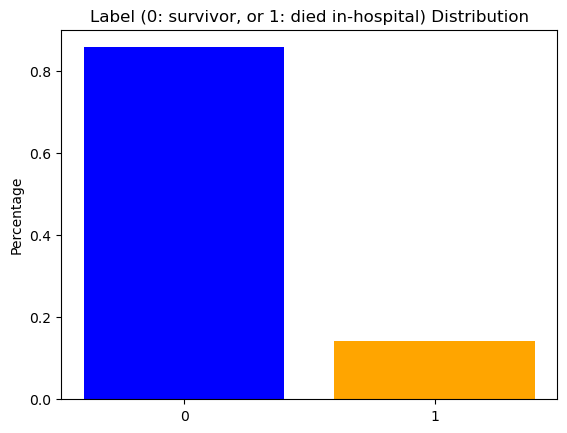

In [6]:
train_set = dm.ds_train
val_set = dm.ds_val
test_set = dm.ds_test

total_size = len(train_set) + len(val_set) + len(test_set)

print("Total Sample Size: ", total_size)
print("Train Split: ", len(train_set), " Val Split: ",  len(val_set), " Test Split: ", len(test_set))

# Label distribution
count_0 = (train_set.y == 0).sum() + (val_set.y == 0).sum() + (test_set.y == 0).sum()
percentage = (count_0 / total_size)

plt.bar(['0', '1'], [percentage, 1 - percentage], color=['blue', 'orange'])
plt.title('Label (0: survivor, or 1: died in-hospital) Distribution')
plt.ylabel('Percentage')
plt.show()

## Data Process

### Splitting Data

We use torchtime to load Physio2012 data with predefined train/val/test splits (70%, 15%, 15%)


### Input Representation Processing

Input data X includes 37 Time Series data and 6 General Descriptors. 

We process the 37 Time Series data by splitting the full sequence of each of the patient's time series event into equal lengthed bins. This results in a 2d binned input matrix of shape (37 event type, # bins) where each bin contains a value that is the aggregation of values that occured within that bin's time frame. This aggregation can be the mean, max, min or last value observed for that bin.

This transforms the irregular input data into regularly sampled data with bin number acting as a control over the trade-off between information granularity and computational complexity.

We seperatly collect the General Descriptors as static input

Final x representation:
  -  x = (Binned event values, General Descriptors, Bin Boundaries)

Final y representation:
  -  y = In-hospital death (0: survivor, or 1: died in-hospital)


In [7]:
# Code snippet for processing each data point (x, y) based on public repo

def __getitem__(self, i):
    ins = self.X[i, ~torch.isnan(self.X[i,:,0]), :]
    time = ins[:,0] / 60 / 24
    x_static = torch.zeros(self.d_static_num())

	# Split patient events into bins of equal length, and use last ocurring value in each bin as representative value
    x_ts = torch.zeros((self.n_timesteps, self.d_time_series_num()*2))
    for i_t, t in enumerate(time):
        bin = self.n_timesteps - 1 if t == time[-1] else int(t / time[-1] * self.n_timesteps)
        for i_ts in range(1,37):
            x_i = ins[i_t,i_ts]
            if not torch.isnan(x_i).item():
                x_ts[bin, i_ts-1] = (x_i - self.means[i_ts])/(self.stds[i_ts] + 1e-7)
                x_ts[bin, i_ts-1+self.d_time_series_num()] += 1
    bin_ends = torch.arange(1, self.n_timesteps+1) / self.n_timesteps * time[-1]

	# Collect General Descriptors as static input variables
    for i_tab in range(37,45):
        x_i = ins[0, i_tab]
        x_i = (x_i - self.means[i_tab])/(self.stds[i_tab] + 1e-7)
        x_static[i_tab-37] = x_i.nan_to_num(0.)

	# Final x representation, (Binned event values, General Descriptors, Bin Boundaries)
    x = (x_ts, x_static, bin_ends)
    
	# Final y representation, (0: survivor, or 1: died in-hospital)
    y = self.y[i,0]
    if self.temp_cache is not None:
        self.temp_cache[i] = (x, y)

    return x, y

print("Raw Input Example: ")
raw_x = dm.ds_train.X[0]
print("x: (time series dimension, 37+8 Event/Descriptor)")
print("x Shape: ", raw_x.shape)

print("\n")

print("Post-Processed Input Example: ")
x, y  = dm.ds_train.__getitem__(0)

print("x: (Binned event values, General Descriptors, Bin Boundaries)")
print("x Shape: ", (x[0].shape, x[1].shape, x[2].shape))


Raw Input Example: 
x: (time series dimension, 37+8 Event/Descriptor)
x Shape:  torch.Size([215, 45])


Post-Processed Input Example: 
x: (Binned event values, General Descriptors, Bin Boundaries)
x Shape:  (torch.Size([32, 72]), torch.Size([8]), torch.Size([32]))


##   Model
The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.

## Model Architecture:

Model Architecture is implemented and imported from duett.py (Based on Public Paper Repo)

The model consists of a series of DuETT layers followed by classification or self-supervised learning heads.  Each DuETT layer has 2 transformer sublayers that attend to the event and time dimension of the embedding respectively.

The first sublayer (Event transformer) has a multi-head attention over events followed by a feed-forward network in the event dimension.

The second sublayer (Time transformer) has a multi-head attention over time bins followed by a feed-forward network operating along the time dimension


### Model Code Snippet:

```
	# For any special timesteps, e.g., masked, static, [CLS], etc.

	self.special_embeddings = nn.Embedding(8, d_embedding)

	# Create list of MLP for embedding each event time series

	self.embedding_layers = nn.ModuleList([
		simple_mlp(2, d_embedding, n_hidden_mlp_embedding, d_hidden_mlp_embedding, hidden_batch_norm=True)
		for _ in range(d_time_series_num)])

	# Embedding for number of observations

	self.n_obs_embedding = nn.Embedding(16, 1)

	if d_feedforward is None:
		d_feedforward = d_embedding * 4

	# Calculate dimensions for event and time transformer inputs. 

	et_dim = d_embedding*(masked_transform_timesteps+1)
	tt_dim = d_embedding*(d_time_series_num+1)

	# Event transformer 

	self.event_transformers = nn.ModuleList([x_transformers.Encoder(dim=et_dim, depth=1,
			heads=n_transformer_head, pre_norm=norm_first, use_scalenorm=scalenorm,
			attn_dim_head=d_embedding//n_transformer_head, ff_glu=glu,
			ff_mult=d_feedforward/et_dim, attn_dropout=transformer_dropout,
			ff_dropout=transformer_dropout) for _ in range(n_duett_layers)])

	# Embedding layer for full events

	self.full_event_embedding = nn.Embedding(d_time_series_num + 1, et_dim)

	# Time transformer 

	self.time_transformers = nn.ModuleList([x_transformers.Encoder(dim=tt_dim, depth=1,
			heads=n_transformer_head, pre_norm=norm_first, use_scalenorm=scalenorm,
			attn_dim_head=d_embedding//n_transformer_head, ff_glu=glu,
			ff_mult=d_feedforward/tt_dim, attn_dropout=transformer_dropout,
			ff_dropout=transformer_dropout) for _ in range(n_duett_layers)])

	# Embedding layer for full time

	self.full_time_embedding =  self.cve(batch_norm=True, d_embedding=tt_dim)
	self.full_rep_embedding = nn.Embedding(tt_dim, 1)

	# time_series + static

	d_representation = d_embedding * (d_time_series_num + 1) 
	self.head = simple_mlp(d_representation, d_target, n_hidden_head, d_hidden_head,
			hidden_batch_norm=True, final_activation=False, activation=nn.ReLU)
	self.pretrain_value_proj = simple_mlp(d_representation, d_time_series_num,
			pretrain_n_hidden, pretrain_d_hidden, hidden_batch_norm=True)
```

## Training

The paper notes that the experiments are done on a single NVidia A6000 GPU. The most resource-intensive pre-training and fine-tuning procedure only uses 7GB of GPU memory and completes within two days.

This notebook was ran with a GTX 1080 with 8GB of GPU Memory. Total training time ~6hrs

## Pretraining

Uses masked event modeling to train the model to capture important priors. This masking scheme is done along both time and event dimensions and predicts both the presence and absence of an event. 

Max of 50 epochs while monitoring validation loss. Best model is saved as checkpoint.

We use F.binary_cross_entropy_with_logits for loss and Adam for optimizer.

Hyperparameters: lr=3.e-4, weight_decay=1.e-1


In [8]:
print(torch.cuda.is_available())


if torch.cuda.is_available():
	gpus = 1
	print("Current CUDA device: ", torch.cuda.current_device())
	print("Device name: ", torch.cuda.get_device_name(0))
else:
    gpus = 0

True
Current CUDA device:  0
Device name:  NVIDIA GeForce GTX 1080


In [9]:
# Pre-training Code that monitors validation performance
if training:
	pretrain_model = duett.pretrain_model(d_static_num=dm.d_static_num(),
			d_time_series_num=dm.d_time_series_num(), d_target=dm.d_target(), pos_frac=dm.pos_frac(),
			seed=seed)
	checkpoint = pl.callbacks.ModelCheckpoint(save_last=True, monitor='val_loss', mode='min', save_top_k=1, dirpath='checkpoints')
	warmup = train.WarmUpCallback(steps=2000)
	logger = CSVLogger("logs", name="pre_train")
	trainer = pl.Trainer(gpus=gpus, logger=logger, num_sanity_val_steps=2, max_epochs=300,
			gradient_clip_val=1.0, callbacks=[warmup, checkpoint])
	trainer.fit(pretrain_model, dm)


In [10]:
def plot_pretrain(file_path):
	df = pd.read_csv(file_path)
    
	val_loss = df['val_loss'].dropna().to_numpy()
	train_loss = df['train_loss'].dropna().to_numpy()

	# Visualize train/val loss metrics
	plt.figure(figsize=(10, 5))
	plt.plot(train_loss, label='Train Loss', color='blue')
	plt.plot(val_loss, label='Validation Loss', color='orange')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.title('Training and Validation Losses')
	plt.legend()
	plt.grid(True)
	plt.show()

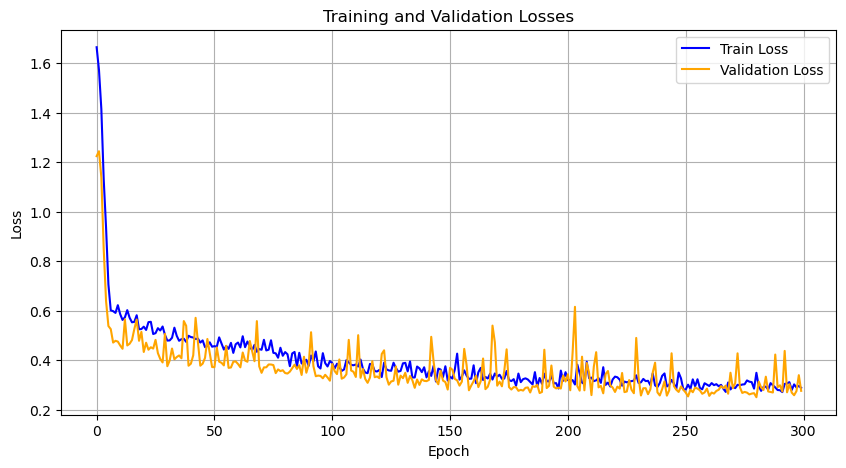

In [11]:
if training:
	versions = [int(version.split("_")[1]) for version in os.listdir("logs/pre_train") if version.startswith("version_")]
	versions.sort(reverse=True)
	file_path = os.path.join("logs/pre_train", f"version_{versions[0]}", "metrics.csv")
else:
	file_path = "metrics/pre_train_metrics.csv"

plot_pretrain(file_path)

In [12]:
if training:
	pretrained_path = checkpoint.best_model_path
else:
	pretrained_path = "pre_computed_checkpoints\pretrained.ckpt"

print("Pre-trained Checkpoint Path: ", pretrained_path)

Pre-trained Checkpoint Path:  pre_computed_checkpoints\pretrained.ckpt


## Fine-Tuning

Fine-tuning in a supervised manner after pretraining. We fine-tune on 3 seeds (2020, 2021, 2022), and take the average of the top 5 models from each to obtain the final model for that seed.

Hyperparameters:
epochs=50
transformer_dropout=0.5
lr=1.e-4
weight_decay=1.e-5

We measure the performence by AUROC and Average Precision on the validation set. 

In [13]:
# Fine-tune and average model over 3 seeds (same as Paper)

if training:
	for seed in range(2020, 2023):
		pl.seed_everything(seed)
		fine_tune_model = duett.fine_tune_model(pretrained_path, d_static_num=dm.d_static_num(),
				d_time_series_num=dm.d_time_series_num(), d_target=dm.d_target(), pos_frac=dm.pos_frac(), seed=seed)
		
		fine_tune_model.train_loss = []
		fine_tune_model.val_loss = []

		path = 'checkpoints/' + str(seed)
		os.makedirs(path, exist_ok=True)

		checkpoint = pl.callbacks.ModelCheckpoint(save_top_k=5, save_last=False, mode='max', monitor='val_ap', dirpath=path)
		warmup = train.WarmUpCallback(steps=1000)

		log_name = "fine_tune_" + str(seed)

		logger = CSVLogger("logs", name=log_name)
		trainer = pl.Trainer(gpus=gpus, logger=logger, max_epochs=50, gradient_clip_val=1.0,
				callbacks=[warmup, checkpoint])
		trainer.fit(fine_tune_model, dm)


In [14]:
def plot_fine_tune(val_auroc, val_ap, train_auroc, train_ap):
	plt.figure(figsize=(10, 5))
	for i in range(3):
		plt.plot(val_auroc[i], label='Validation' if i == 0 else '', alpha=0.7, color='orange') 
		plt.plot(train_auroc[i], label='Training' if i == 0 else '', alpha=0.7, color='blue') 
	plt.xlabel('Epoch')
	plt.ylabel('AUROC')
	plt.title('Fine-tuned Validation AUROC')
	plt.legend()
	plt.grid(True)
	plt.show()

	plt.figure(figsize=(10, 5))
	for i in range(3):
		plt.plot(val_ap[i], label='Validation' if i == 0 else '', alpha=0.7, color='orange') 
		plt.plot(train_ap[i], label='Training' if i == 0 else '', alpha=0.7, color='blue') 
	plt.xlabel('Epoch')
	plt.ylabel('Avg Precision')
	plt.title('Fine-tuned Validation Avg Precision')
	plt.legend()
	plt.grid(True)
	plt.show()

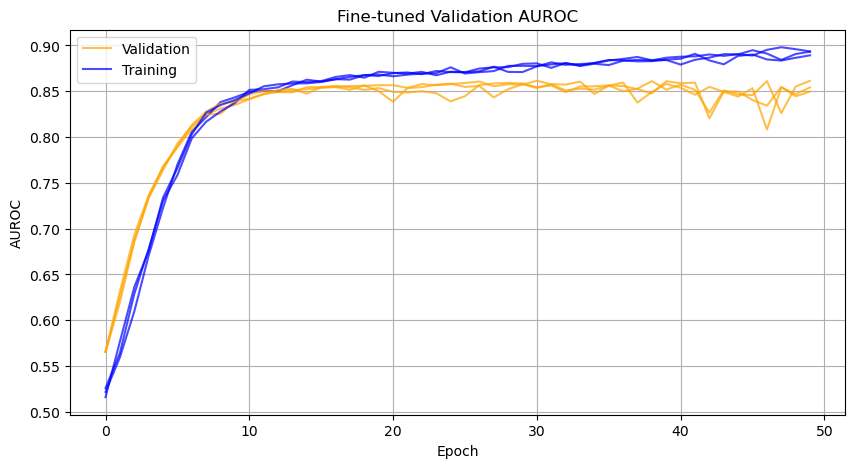

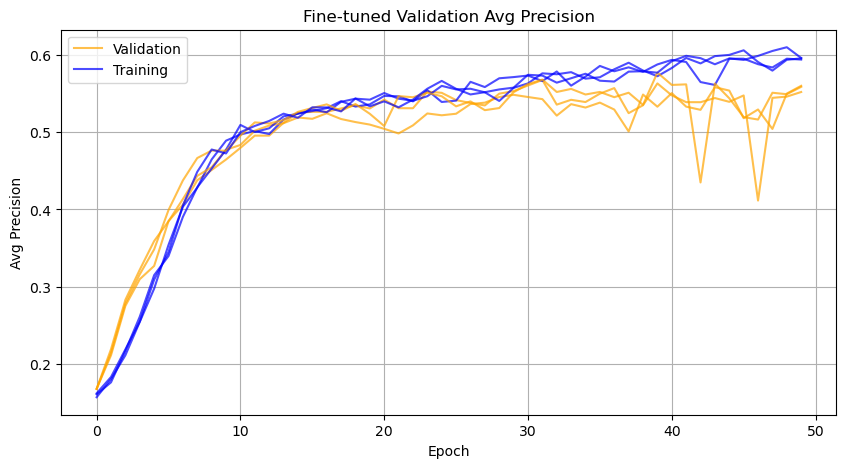

In [15]:
# Load fine-tune performance gain (AUROC, AP)
val_auroc = []
val_ap = []

train_auroc = []
train_ap = []

for seed in range(2020, 2023):
	if training:
		log_path = "logs/fine_tune_" + str(seed)
		versions = [int(version.split("_")[1]) for version in os.listdir(log_path) if version.startswith("version_")]
		versions.sort(reverse=True)
		file_path = os.path.join(log_path, f"version_{versions[0]}", "metrics.csv")
	else:
		file_path = "metrics/fine_tune_" + str(seed) + "_metrics.csv"

	df = pd.read_csv(file_path)

	val_auroc.append(df['val_auroc'].dropna().to_numpy())
	val_ap.append(df['val_ap'].dropna().to_numpy())

	train_auroc.append(df['train_auroc'].dropna().to_numpy())
	train_ap.append(df['train_ap'].dropna().to_numpy())

plot_fine_tune(val_auroc, val_ap, train_auroc, train_ap)

# Results

Following Pre-training and Fine-Tuning, we run the 3 final models on the test set and measure the average/std of AUROC and Average Precision.

We compare the results with XGBoost, LSTM, mTAND, Raindrop, STraTs on the PhysioNet-2012 mortality


In [16]:
# Get final model for each seed by averaging the weight of the best checkpoints
best_models = []

for i in range(2020, 2023):
	if training:
		dir_path = 'checkpoints/' + str(i)
	else:
		dir_path = 'pre_computed_checkpoints/fine_tuned/' + str(i)

	top_k = [os.path.join(dir_path, filename) for filename in os.listdir(dir_path)]

	print(top_k)

	best_models.append(train.average_models([duett.fine_tune_model(path, d_static_num=dm.d_static_num(),
		d_time_series_num=dm.d_time_series_num(), d_target=dm.d_target(), pos_frac=dm.pos_frac())
		for path in top_k]))

['pre_computed_checkpoints/fine_tuned/2020\\epoch=29-step=510.ckpt', 'pre_computed_checkpoints/fine_tuned/2020\\epoch=30-step=527.ckpt', 'pre_computed_checkpoints/fine_tuned/2020\\epoch=31-step=544.ckpt', 'pre_computed_checkpoints/fine_tuned/2020\\epoch=36-step=629.ckpt', 'pre_computed_checkpoints/fine_tuned/2020\\epoch=39-step=680.ckpt']
Loading from checkpoint
Loading from checkpoint


c:\Users\jjang\miniconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\jjang\miniconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Loading from checkpoint
Loading from checkpoint
Loading from checkpoint
['pre_computed_checkpoints/fine_tuned/2021\\epoch=40-step=697.ckpt', 'pre_computed_checkpoints/fine_tuned/2021\\epoch=43-step=748.ckpt', 'pre_computed_checkpoints/fine_tuned/2021\\epoch=44-step=765.ckpt', 'pre_computed_checkpoints/fine_tuned/2021\\epoch=48-step=833.ckpt', 'pre_computed_checkpoints/fine_tuned/2021\\epoch=49-step=850.ckpt']
Loading from checkpoint
Loading from checkpoint
Loading from checkpoint
Loading from checkpoint
Loading from checkpoint
['pre_computed_checkpoints/fine_tuned/2022\\epoch=30-step=527.ckpt', 'pre_computed_checkpoints/fine_tuned/2022\\epoch=31-step=544.ckpt', 'pre_computed_checkpoints/fine_tuned/2022\\epoch=39-step=680.ckpt', 'pre_computed_checkpoints/fine_tuned/2022\\epoch=41-step=714.ckpt', 'pre_computed_checkpoints/fine_tuned/2022\\epoch=43-step=748.ckpt']
Loading from checkpoint
Loading from checkpoint
Loading from checkpoint
Loading from checkpoint
Loading from checkpoint


In [17]:
# Run final model on test set
test_auroc = []
test_ap = []

warmup = train.WarmUpCallback(steps=1000)
trainer = pl.Trainer(gpus=gpus, logger=False,
		callbacks=[warmup])

for final_model in best_models:
	result = trainer.test(final_model, dataloaders=dm)

	test_auroc.append(result[0]['test_auroc'])
	test_ap.append(result[0]['test_ap'])

c:\Users\jjang\miniconda3\lib\site-packages\pytorch_lightning\loops\utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


warmup_steps 1000, base_lr None, invsqrt True, decay None
Validating cache...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\jjang\miniconda3\lib\site-packages\torch\utils\data\dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_ap            0.5532841086387634
       test_auroc           0.8711923956871033
        test_loss           0.48061360888288585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validating cache...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\jjang\miniconda3\lib\site-packages\torch\utils\data\dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_ap            0.5511272549629211
       test_auroc           0.8731151819229126
        test_loss           0.48443825549777847
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validating cache...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\jjang\miniconda3\lib\site-packages\torch\utils\data\dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_ap            0.5585983991622925
       test_auroc           0.8716351985931396
        test_loss           0.4843648356732372
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [18]:
# Display final results averaged over 3 seed (2020, 2021, 2022)
mean_auroc_result = np.mean(test_auroc)
std_auroc_result = np.std(test_auroc)
mean_ap_result = np.mean(test_ap)
std_ap_result = np.std(test_ap)

print("Mean AUROC: ", f"{mean_auroc_result:.3f} ± {std_auroc_result:.3f}")
print("Mean AP: ", f"{mean_ap_result:.3f} ± {std_ap_result:.3f}")

Mean AUROC:  0.872 ± 0.001
Mean AP:  0.554 ± 0.003


## Model comparison

PhysioNet-2012 Mortality Task Performance

Below is our model's best performance compared with other methods. Other method's performance data is sourced from the original paper.
All methods use seed 2020 with ours using seed 2020-2022.

| Model           | ROC-AUC    | PR-AUC    |
|-----------------|------------|-----------|
| XGBoost         | 0.865 ± 0.001 | 0.531 ± 0.009 |
| LSTM            | 0.848 ± 0.002 | 0.494 ± 0.002 |
| mTAND           | 0.857 ± 0.001 | 0.515 ± 0.007 |
| Raindrop         | 0.838 ± 0.009 | 0.479 ± 0.002 |
| STraTS           | 0.852 ± 0.008 | 0.527 ± 0.006 |
| **DuETT (Ours)**    | **0.872 ± 0.001** | **0.554 ± 0.003** |

We see that our method achieves better results compared to all other methods on the AUROC and PR metric and matches the performance described in the paper.


## Ablation Study

In [19]:
# Result Visualization Code

def visualize_ablation(ablation_num):
	df = pd.read_csv("metrics/ablation_" + str(ablation_num) + "/result.csv")
	test_auroc = df['test_auroc'].dropna().to_numpy()
	test_ap = df['test_ap'].dropna().to_numpy()

	ap_delta = np.mean(test_ap) - mean_ap_result

	print("Ablation AUROC: ", f"{np.mean(test_auroc):.3f} ± {np.std(test_auroc):.3f}")
	print("Ablation AP: ", f"{np.mean(test_ap):.3f} ± {np.std(test_ap):.3f}")
	print("AP Difference from Main Result: ", f"{ap_delta:.3f}")

	pre_train_path = "metrics/ablation_" + str(ablation_num) + "/pre_train.csv"
	if os.path.exists(pre_train_path):
		plot_pretrain(pre_train_path)

	for seed in range(2020, 2023):
		file_path = "metrics/ablation_" + str(ablation_num) + "/" + str(seed) + "_metrics.csv"

		df = pd.read_csv(file_path)

		val_auroc.append(df['val_auroc'].dropna().to_numpy())
		val_ap.append(df['val_ap'].dropna().to_numpy())

		train_auroc.append(df['train_auroc'].dropna().to_numpy())
		train_ap.append(df['train_ap'].dropna().to_numpy())

	plot_fine_tune(val_auroc, val_ap, train_auroc, train_ap)

###   Input representation ablations: 


1. Investigate the choice of injecting event & time embedding at each layer which should by only injecting at the first layer.

Original Code (Injecting event & time embedding at each layer):

```
for layer_i, (event_transformer, time_transformer) in enumerate(zip(self.event_transformers, self.time_transformers)):
    et_out_shape = (psi.shape[0], psi.shape[2], psi.shape[1], psi.shape[3])
    embeddings = psi.transpose(1,2).flatten(2) + self.full_event_embedding.weight.unsqueeze(0)
    event_outs = event_transformer(embeddings).view(et_out_shape).transpose(1,2)
    tt_out_shape = event_outs.shape
    embeddings = event_outs.flatten(2) + time_embeddings
    psi = time_transformer(embeddings).view(tt_out_shape)
```

Ablation Code (Only Injecting event & time embedding at first layer):

```
et_out_shape = (psi.shape[0], psi.shape[2], psi.shape[1], psi.shape[3])
embeddings = psi.transpose(1,2).flatten(2) + self.full_event_embedding.weight.unsqueeze(0)
event_outs = self.event_transformers[0](embeddings).view(et_out_shape).transpose(1,2)
tt_out_shape = event_outs.shape
embeddings = event_outs.flatten(2) + time_embeddings
psi = self.time_transformers[0](embeddings).view(tt_out_shape)
```

Ablation AUROC:  0.867 ± 0.004
Ablation AP:  0.550 ± 0.002
AP Difference from Main Result:  -0.004


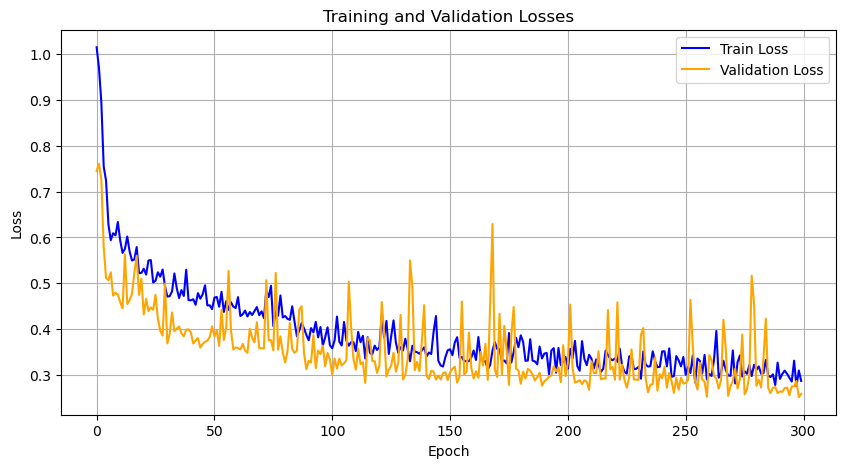

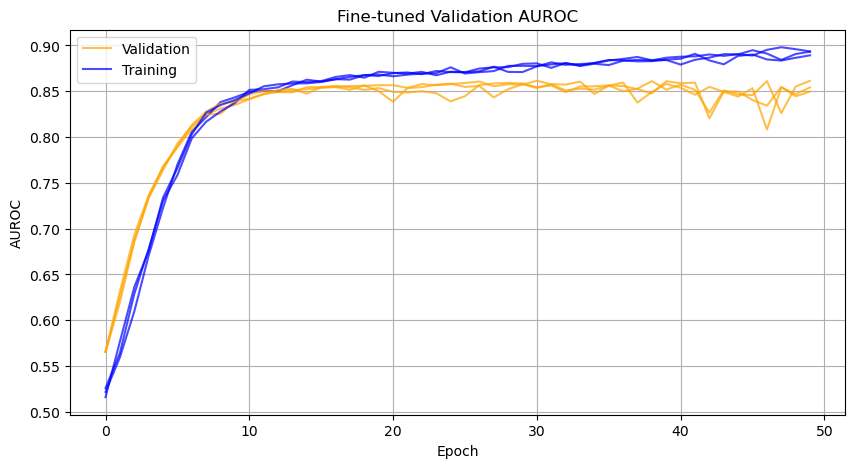

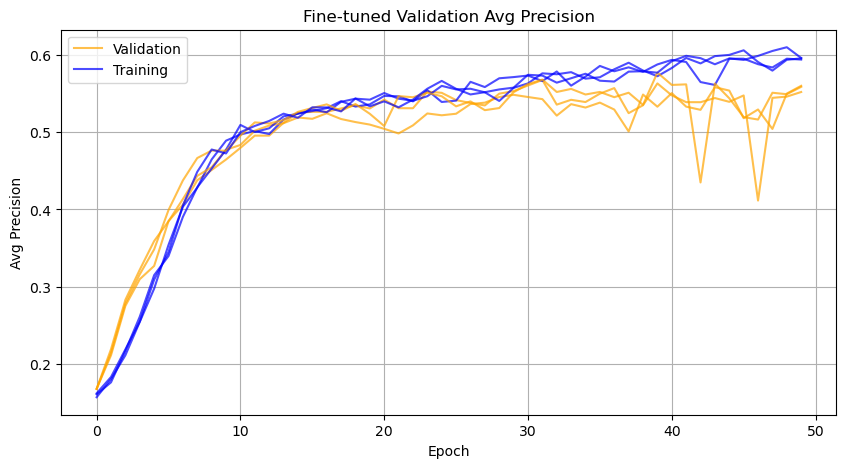

In [20]:
# Visualize results
visualize_ablation(1)

2. Investigate the use of the last occurring value in the bin as the aggregation functions of bins by comparing the performance with mean aggregation.

Original Code (Use last occurring value as aggregation):

```
for i_t, t in enumerate(time):
	bin = self.n_timesteps - 1 if t == time[-1] else int(t / time[-1] * self.n_timesteps)
	for i_ts in range(1,37):
		x_i = ins[i_t,i_ts]
		if not torch.isnan(x_i).item():
			x_ts[bin, i_ts-1] = (x_i - self.means[i_ts])/(self.stds[i_ts] + 1e-7)
			x_ts[bin, i_ts-1+self.d_time_series_num()] += 1
```

Ablation Code (Use mean value as aggregation):

```
for i_t, t in enumerate(time):
	bin = self.n_timesteps - 1 if t == time[-1] else int(t / time[-1] * self.n_timesteps)
	for i_ts in range(1,37):
		x_i = ins[i_t,i_ts]
		if not torch.isnan(x_i).item():
			# Sum up values
			x_ts[bin, i_ts-1] += (x_i - self.means[i_ts])/(self.stds[i_ts] + 1e-7)
			# Accumulate occurance count
			x_ts[bin, i_ts-1+self.d_time_series_num()] += 1

# Divide sum by count
for bin_idx in range(self.n_timesteps):
	for i_ts in range(self.d_time_series_num()):
		count = x_ts[bin_idx, i_ts + self.d_time_series_num()]
		if count > 0:
			x_ts[bin_idx, i_ts] /= count
```

Ablation AUROC:  0.867 ± 0.001
Ablation AP:  0.552 ± 0.009
AP Difference from Main Result:  -0.002


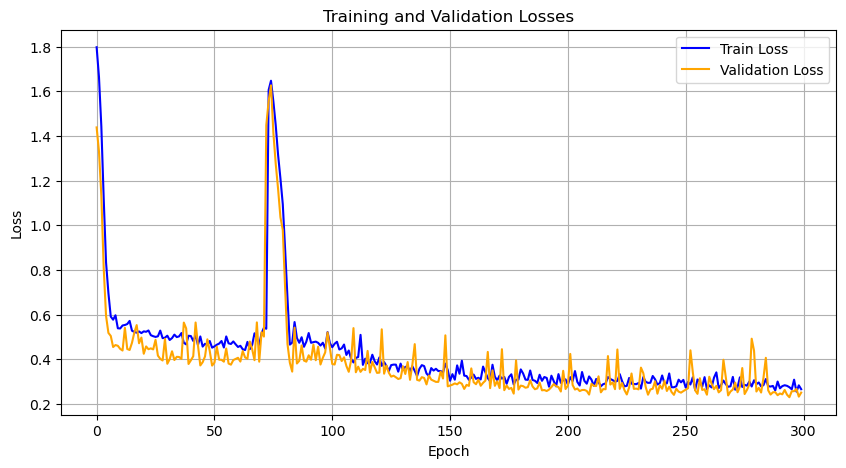

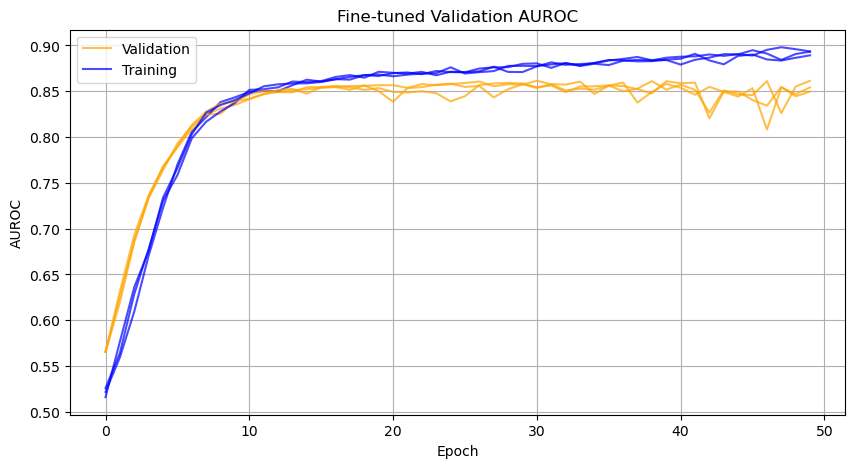

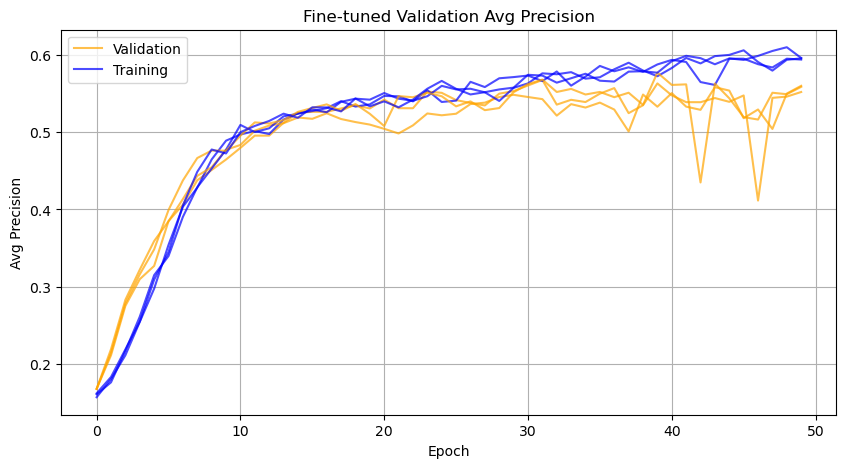

In [21]:
# Visualize results
visualize_ablation(2)

###  Self-Supervised Learning Ablation: 

Investigate the impact of pre-training by skipping it entirely.

Original Code (Pre-train first then load from checkpoint with fine-tune parameters)

```
def pretrain_model(d_static_num, d_time_series_num, d_target, **kwargs):
    return Model(d_static_num, d_time_series_num, d_target, **kwargs)

def fine_tune_model(ckpt_path, **kwargs):
    return Model.load_from_checkpoint(ckpt_path, pretrain=False, aug_noise=0., aug_mask=0.5, transformer_dropout=0.5,
            lr=1.e-4, weight_decay=1.e-5, fusion_method='rep_token', **kwargs)
```

Ablation Code (Directly create model with fine-tune parameters)

```
def skip_pretrain_model(d_static_num, d_time_series_num, d_target, **kwargs):
    return Model(d_static_num, d_time_series_num, d_target, pretrain=False, aug_noise=0., aug_mask=0.5, transformer_dropout=0.5,
            lr=1.e-4, weight_decay=1.e-5, fusion_method='rep_token', **kwargs)
```

Ablation AUROC:  0.856 ± 0.001
Ablation AP:  0.515 ± 0.005
AP Difference from Main Result:  -0.039


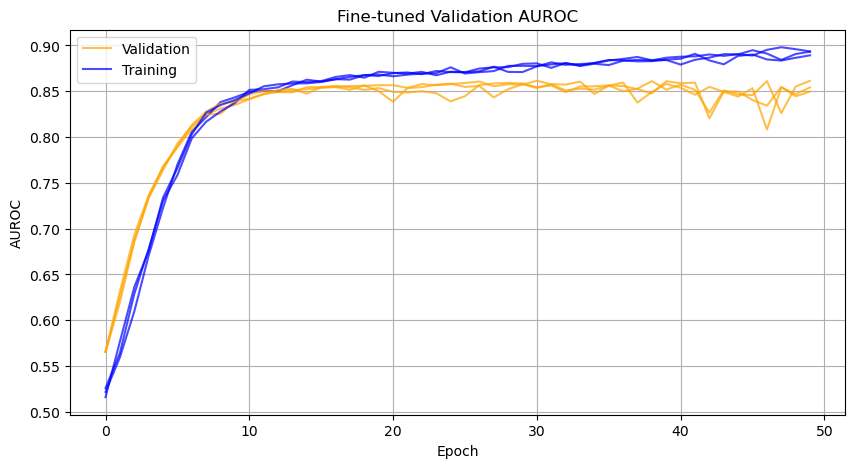

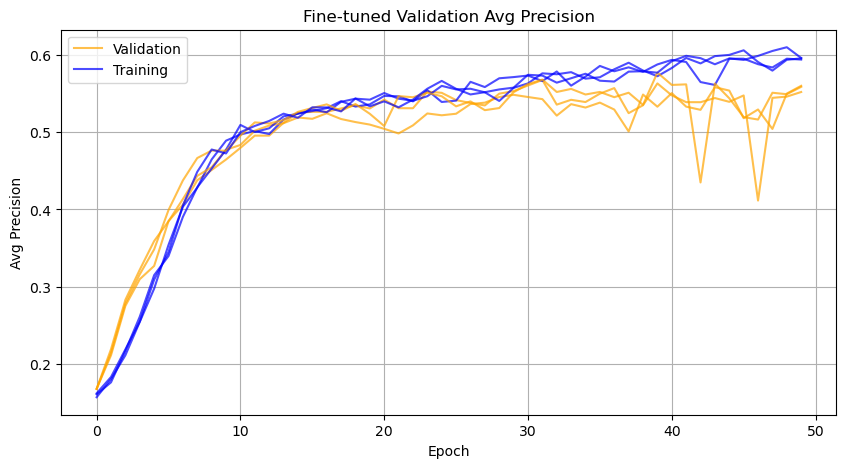

In [22]:
# Visualize results
visualize_ablation(3)

### Dual event & time transformer Ablation: 


Investigate the impact of having both event and time transformers by only having either event or time transformers.

Original Code (Both event and time transformer for embeddings)

```
for layer_i, (event_transformer, time_transformer) in enumerate(zip(self.event_transformers, self.time_transformers)):
	et_out_shape = (psi.shape[0], psi.shape[2], psi.shape[1], psi.shape[3])
	embeddings = psi.transpose(1,2).flatten(2) + self.full_event_embedding.weight.unsqueeze(0)
	event_outs = event_transformer(embeddings).view(et_out_shape).transpose(1,2)
	tt_out_shape = event_outs.shape
	embeddings = event_outs.flatten(2) + time_embeddings
	psi = time_transformer(embeddings).view(tt_out_shape)
```

Ablation Code (Event transformer for embedding only)

```
for layer_i, (event_transformer, time_transformer) in enumerate(zip(self.event_transformers, self.time_transformers)):
	et_out_shape = (psi.shape[0], psi.shape[2], psi.shape[1], psi.shape[3])
	embeddings = psi.transpose(1,2).flatten(2) + self.full_event_embedding.weight.unsqueeze(0)
	event_outs = event_transformer(embeddings).view(et_out_shape).transpose(1,2)
	tt_out_shape = event_outs.shape
	psi = event_outs
```

Ablation Code (Time transformer for embedding only)

```
for layer_i, (event_transformer, time_transformer) in enumerate(zip(self.event_transformers, self.time_transformers)):
	et_out_shape = (psi.shape[0], psi.shape[2], psi.shape[1], psi.shape[3])
	embeddings = psi.flatten(2) + time_embeddings
	psi = time_transformer(embeddings).view(et_out_shape).transpose(1,2)
```

Ablation AUROC:  0.865 ± 0.001
Ablation AP:  0.535 ± 0.006
AP Difference from Main Result:  -0.019


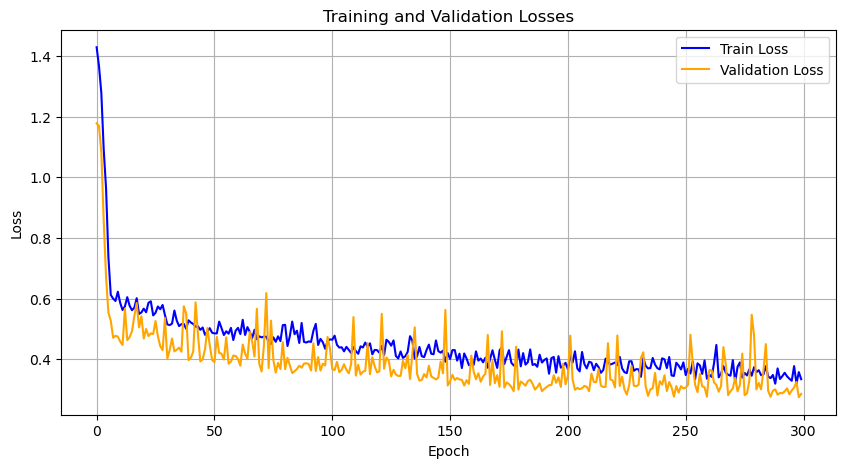

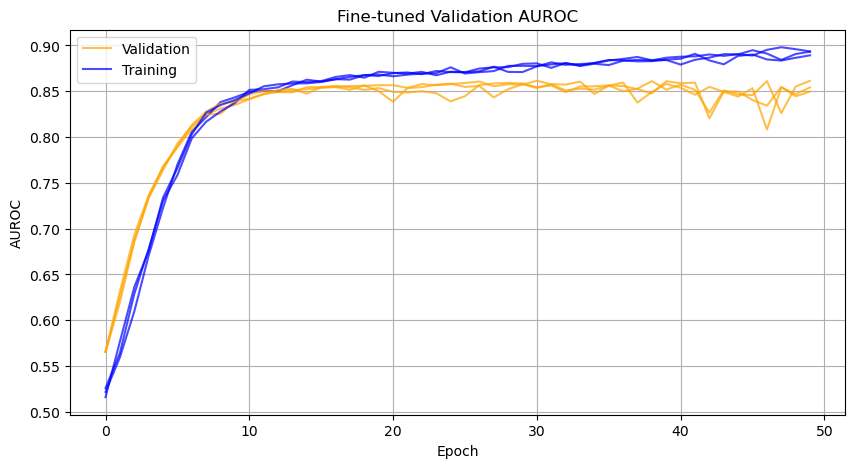

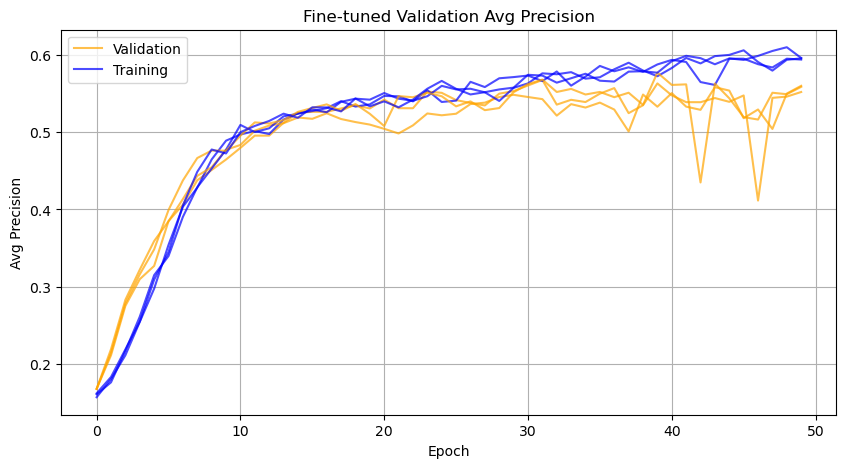

In [23]:
# Visualize Event transformer only results
visualize_ablation(4)

Ablation AUROC:  0.855 ± 0.004
Ablation AP:  0.522 ± 0.004
AP Difference from Main Result:  -0.032


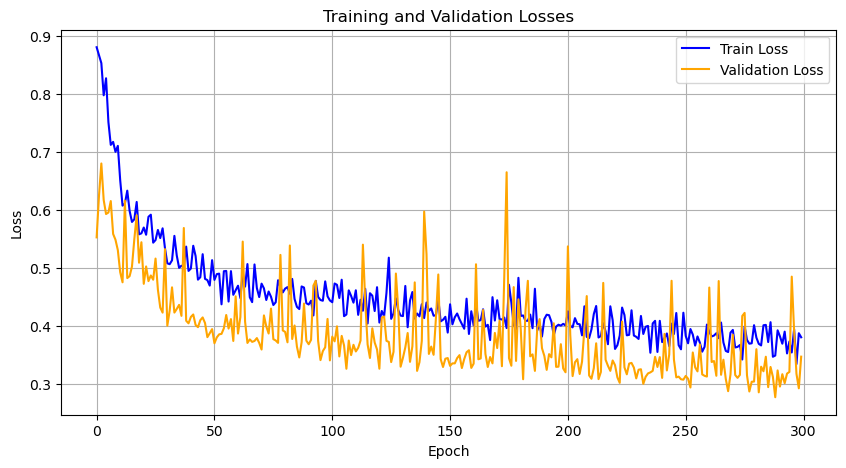

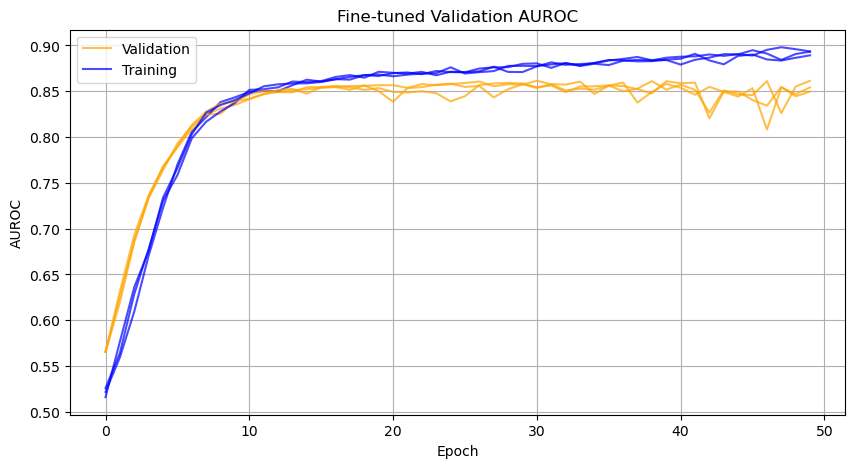

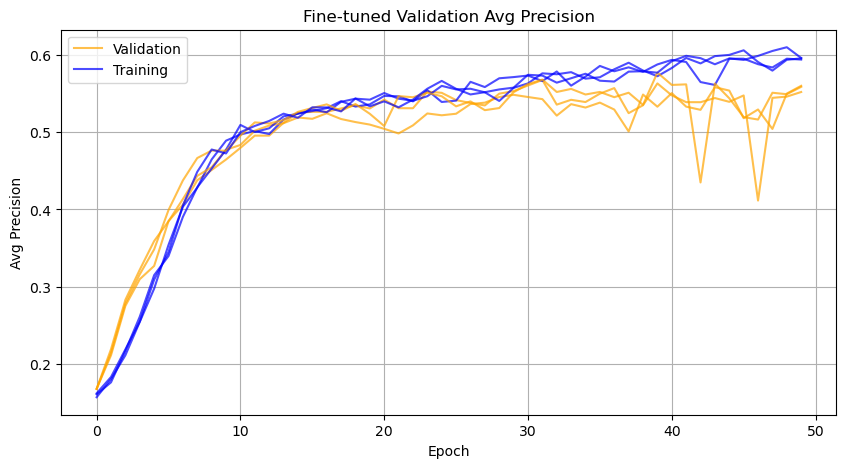

In [24]:
# Visualize Time transformer only results
visualize_ablation(5)

| Ablation Study           | PR-AUC    | $$\Delta$$    |
|-----------------|------------|-----------|
| **DuETT** 		  |	**0.554 ± 0.003** |  |
| First layer embedding only         | 0.550 ± 0.002 | -0.004 |
| Binning with mean aggregation            | 0.552 ± 0.009 | -0.002 |
| No Pre-training           | 0.515 ± 0.005 | -0.039 |
| Event Transformer Only         | 0.535 ± 0.006 | -0.019 |
| Time Transformer Only           | 0.522 ± 0.004 | -0.032 |


# Discussion

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase.







This paper's results were reproducible due to the availability of the original code with all hyperparameter provided. We were able to achieve similar performance as the original paper and was able to achieve better performance on the Physio2012 Mortality task when compared with other methods.

It was relatively simple to replicate the code and algorithm of the model. However, due to the lengthiness of the training process, our device would run out of memory and fail to complete the trainng. While we were able to use lighting module's checkpoint to recover the progress, some hiccups were introduced with metric tracking for visualization process. Some suggestion would also be to include more comments in the code for better readability as well as visualization of the data set and training process.

In the next phase, we will conduct the following ablation studies, and report on the results.

1.   Input representation ablations: 
      - Investigate the use of the last occurring value in the bin as the aggregation functions of bins by comparing the performance with other methods (mean, max). 
      - Investigate the choice of injecting event & time embedding at each layer which should by only injecting at the first layer.
2.   Self-Supervised Learning Ablation: 
      - Investigate the impact of pre-training by skipping it entirely.
3.   Dual event & time transformer Ablation: 
      - Investigate the impact of having both event and time transformers by only having either event or time transformers.

# References


1.   Labach, A., Pokhrel, A., Huang, X. S., Zuberi, S., Yi, S. E., Volkovs, M., Poutanen, T., & Krishnan, R. G. DuETT: Dual Event Time Transformer for Electronic Health Records. arXiv, 2023, arXiv:2304.13017, doi: https://doi.org/10.48550/arXiv.2304.13017


